In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import OsteoArthNet as OAN
from tqdm import tqdm

In [4]:
plt.style.use('seaborn')

### Import Dataset

In [5]:
train_df = pd.read_csv('./Dataset/SARS-COV-2/train.csv')
val_df = pd.read_csv('./Dataset/SARS-COV-2/val.csv')
test_df = pd.read_csv('./Dataset/SARS-COV-2/test.csv')

In [6]:
train_df.head()

,path,label
0,./Dataset/SARS-COV-2/non-COVID/Non-Covid (290)...,0
1,./Dataset/SARS-COV-2/COVID/Covid (481).png,1
2,./Dataset/SARS-COV-2/non-COVID/Non-Covid (478)...,0
3,./Dataset/SARS-COV-2/non-COVID/Non-Covid (400)...,0
4,./Dataset/SARS-COV-2/non-COVID/Non-Covid (36).png,0


### Plot Some Images

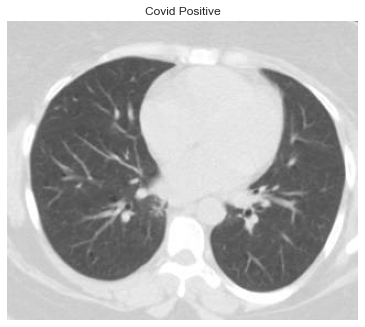

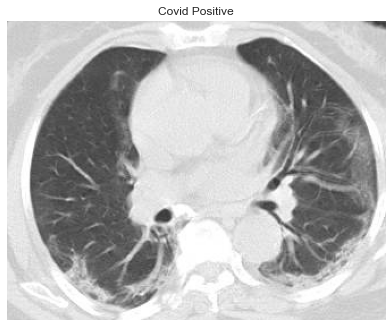

In [7]:
# COVID Negative
non_covid = image.load_img('./Dataset/SARS-COV-2/non-COVID/Non-Covid (290).png')
plt.imshow(non_covid)
plt.axis('off')
plt.title("Covid Positive")
plt.show()


#COVID Positive
covid = image.load_img('./Dataset/SARS-COV-2/COVID/Covid (481).png')
plt.imshow(covid)
plt.axis('off')
plt.title("Covid Positive")
plt.show()

### Build Train Generator

In [8]:
class TrainImageGenerator():

    def __init__(self, target_size, batch_size, class_mode):
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode
        
    def TrainGenerator(self):
        train_idg = image.ImageDataGenerator(
            rescale = 1./255,
        )

        train_generator = train_idg.flow_from_dataframe(
            train_df,
            x_col = 'path',
            y_col = 'label',
            seed = 4,
            shuffle = True,
            target_size = self.target_size,
            batch_size = self.batch_size,
            class_mode = self.class_mode
        )

        return train_generator

In [9]:
trainimgGenerator = TrainImageGenerator((224,224),4,'raw')
train_generator = trainimgGenerator.TrainGenerator()

Found 2008 validated image filenames.


### Build Validation Generator

In [10]:
class ValImageGenerator():

    def __init__(self, target_size, batch_size, class_mode):
        self.target_size = target_size
        self.batch_size = batch_size
        self.class_mode = class_mode
        
    def ValGenerator(self):
        val_idg = image.ImageDataGenerator(
            rescale = 1./255,
        )

        val_generator = val_idg.flow_from_dataframe(
            val_df,
            x_col = 'path',
            y_col = 'label',
            seed = 4,
            shuffle = True,
            target_size = self.target_size,
            batch_size = self.batch_size,
            class_mode = self.class_mode
        )

        return val_generator

In [11]:
valimgGenerator = ValImageGenerator((224,224),4,'raw')
val_generator = valimgGenerator.ValGenerator()

Found 249 validated image filenames.


### Model Hyperparameters

In [12]:
EPOCHS = 50
BATCH_SIZE = 4
INPUT_SHAPE = (224, 224, 3)
LEARNING_RATE = 0.0001
NO_OF_CLASSES = 1

### Callbacks & Checkpoints

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [14]:
checkpoint_path = './Model_Checkpoints'
if not os.path.exists(checkpoint_path):
    os.mkdir(checkpoint_path)
else:
    print("Folder Exists")

Folder Exists


In [15]:
model_hist_path = './Model_History'
if not os.path.exists(model_hist_path):
    os.mkdir(model_hist_path)
else:
    print("Folder Exists")

Folder Exists


In [16]:
model_checkpoint_path = checkpoint_path + '/SARS-COVID.ckpt' 

# Set Callbacks
my_callbacks = [
                ModelCheckpoint(filepath = model_checkpoint_path,
                    monitor = 'val_acc',
                    verbose = 1,
                    save_weights_only=True,
                    save_best_only = True,
                    mode="max"
                ),
                EarlyStopping(monitor='val_acc',
                    patience=20,
                    verbose=1
                ),
                ReduceLROnPlateau(monitor='val_acc',
                    patience=20,
                    verbose=1
                )
]

### OsteoArthNet Training

In [17]:
model_osteoarthnet = OAN.BuildModel(learning_rate=LEARNING_RATE,
                           input_shape=INPUT_SHAPE, 
                           no_of_classes=NO_OF_CLASSES, )

model = model_osteoarthnet.OsteoArthNet()

In [18]:
model_osteoarthnet.model_info()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________

In [19]:
hist = model_osteoarthnet.train_model(train_generator, val_generator, EPOCHS,[my_callbacks])
np.save(f'{model_hist_path}/SARS-COVID.npy',hist.history)

Epoch 1/50
502/502 [==============================] - 35s 49ms/step - loss: 0.5899 - acc: 0.6868 - val_loss: 0.9301 - val_acc: 0.6104

Epoch 00001: val_acc improved from -inf to 0.61044, saving model to ./Model_Checkpoints\SARS-COVID.ckpt
Epoch 2/50
502/502 [==============================] - 22s 43ms/step - loss: 0.4874 - acc: 0.7694 - val_loss: 1.0046 - val_acc: 0.5502

Epoch 00002: val_acc did not improve from 0.61044
Epoch 3/50
502/502 [==============================] - 22s 43ms/step - loss: 0.3769 - acc: 0.8391 - val_loss: 0.4901 - val_acc: 0.7590

Epoch 00003: val_acc improved from 0.61044 to 0.75904, saving model to ./Model_Checkpoints\SARS-COVID.ckpt
Epoch 4/50
502/502 [==============================] - 22s 44ms/step - loss: 0.3389 - acc: 0.8591 - val_loss: 0.3126 - val_acc: 0.8675

Epoch 00004: val_acc improved from 0.75904 to 0.86747, saving model to ./Model_Checkpoints\SARS-COVID.ckpt
Epoch 5/50
502/502 [==============================] - 22s 44ms/step - loss: 0.2785 - acc: 0.


Epoch 00042: val_acc did not improve from 0.93574
Epoch 43/50
502/502 [==============================] - 22s 44ms/step - loss: 2.8417e-04 - acc: 1.0000 - val_loss: 0.3593 - val_acc: 0.9197

Epoch 00043: val_acc did not improve from 0.93574
Epoch 44/50
502/502 [==============================] - 22s 45ms/step - loss: 2.2490e-04 - acc: 1.0000 - val_loss: 0.4408 - val_acc: 0.9197

Epoch 00044: val_acc did not improve from 0.93574
Epoch 45/50
502/502 [==============================] - 22s 45ms/step - loss: 0.0141 - acc: 0.9950 - val_loss: 1.5498 - val_acc: 0.7871

Epoch 00045: val_acc did not improve from 0.93574
Epoch 46/50
502/502 [==============================] - 23s 45ms/step - loss: 0.0205 - acc: 0.9925 - val_loss: 0.5241 - val_acc: 0.8474

Epoch 00046: val_acc did not improve from 0.93574
Epoch 47/50
502/502 [==============================] - 22s 44ms/step - loss: 0.0116 - acc: 0.9935 - val_loss: 0.4567 - val_acc: 0.8755

Epoch 00047: val_acc did not improve from 0.93574
Epoch 48/50

### Feature Extraction from CT-Scan

In [13]:
from tensorflow.keras.models import Model

In [14]:
model_osteoarthnet = OAN.BuildModel()
model = model_osteoarthnet.OsteoArthNet()
model.load_weights('./Model_Checkpoints/SARS-COVID.ckpt')

In [15]:
osteoarthet = Model(inputs=model.input, outputs=model.layers[-2].output)
osteoarthet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
____________________________________________________________________________________________

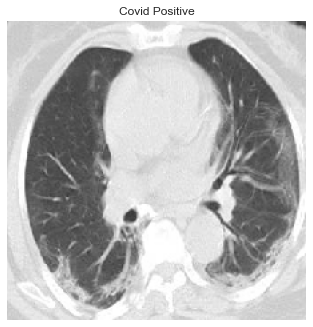

In [16]:
img = image.load_img('./Dataset/SARS-COV-2/COVID/Covid (481).png',target_size=(224,224,3))

plt.imshow(img)
plt.title("Covid Positive")
plt.axis('off')
plt.show()

In [13]:
img = image.img_to_array(img)
img = img.reshape(1,224,224,3)

img = osteoarthet.predict(img)
img.shape

(1, 2048)

In [16]:
# Image Feature Extraction

train_img_feature = {}
test_img_feature = {}

# Extract Features for train
for item in tqdm(train_df.itertuples()):
    temp = []
    img_path = item.path
    img_label = item.label
    img = image.load_img(img_path, target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img.reshape(1,224,224,3)
    
    extracted_feature = osteoarthet.predict(img)
    temp.append(extracted_feature)
    temp.append(img_label)
    
    train_img_feature[img_path] = temp
    
print('Train Image Feature Extraction Completed')


# Extract Features for test
for item in tqdm(test_df.itertuples()):
    temp = []
    img_path = item.path
    img_label = item.label
    img = image.load_img(img_path, target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img.reshape(1,224,224,3)
    
    extracted_feature = osteoarthet.predict(img)
    temp.append(extracted_feature)
    temp.append(img_label)
    
    test_img_feature[img_path] = temp
    
print('Test Image Feature Extraction Completed')

2008it [01:35, 21.13it/s]


Train Image Feature Extraction Completed


224it [00:15, 14.63it/s]

Test Image Feature Extraction Completed


In [22]:
img = cv2.imread('./Dataset/SARS-COV-2/COVID/Covid (481).png')
img = cv2.resize(img, (224,224))
img = image.img_to_array(img)
img = img.reshape(1,224,224,3)

# Load Osteoarthnet
model_osteoarthnet = OAN.BuildModel()
model = model_osteoarthnet.OsteoArthNet()
model.load_weights('./Model_Checkpoints/SARS-COVID.ckpt')
osteoarthet = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract Features
extracted_feature = osteoarthet.predict(img)
extracted_feature = extracted_feature.reshape(1,2048)

In [17]:
import pickle

In [18]:
with open('./Dataset/SARS-COV-2/train.pkl','wb') as f:
    pickle.dump(train_img_feature, f)
    
with open('./Dataset/SARS-COV-2/test.pkl','wb') as f:
    pickle.dump(test_img_feature, f)

### Resnet Training

In [ ]:
model_osteoarthnet = OAN.BuildModel(learning_rate=LEARNING_RATE,
                           input_shape=INPUT_SHAPE, 
                           no_of_classes=NO_OF_CLASSES, )

model = model_osteoarthnet.OsteoArthNet()

In [ ]:
hist = model_osteoarthnet.train_model(train_generator, val_generator, EPOCHS,[my_callbacks])
#np.save(f'{model_hist_path}/SARS-COVID.npy',hist.history)